In [172]:
import sys
import os
from pathlib import Path
import re
import pandas as pd

sys.path.insert(1, '../../notes/1-Testing/fuzzy-test/python/')

In [173]:
from fuzzy_system import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
with open('fuzzy-inputs.txt') as f:
    inputsString = f.read()

In [175]:
with open('fuzzy-rules.txt') as f:
    rulesString = f.read()

In [176]:
inputVariables = []

for axis in inputsString.split("\n\n"):
    if not axis:
        continue

    # Axis: maxParticlesPerCell range: (0.00, 35.00)
    nameStr = re.search(r"Axis: (\w+)", axis).group(1)
    rangeStr = re.search(r"range: \((\d+\.\d+), (\d+\.\d+)\)", axis)

    variable = LinguisticVariable(
        nameStr, (float(rangeStr.group(1)), float(rangeStr.group(2))))

    for rule in axis.strip().split("\n")[1:]:
        name = re.search(r"^\s*(.*):", rule).group(1)
        func = re.search(r": (\w+)\(", rule).group(1)
        params = re.search(r"\((.+)\)", rule).group(1).split(", ")
        if func == "Gaussian":
            variable.addLinguisticTerm(makeGaussian(name,
                                                    float(params[0]), float(params[1])))
        elif func == "Sigmoid":
            variable.addLinguisticTerm(makeSigmoid(
                name, float(params[0]), float(params[1])))

    inputVariables.append(variable)

In [177]:
prediction = LinguisticVariable("prediction", (0, 40))

prediction.addLinguisticTerm(makeGaussian("LinkedCells", 10, 5))
prediction.addLinguisticTerm(makeGaussian("VerletListsCells", 20, 5))
prediction.addLinguisticTerm(makeGaussian("VerletClusterLists", 30, 5))


inputVariables.append(prediction)

algo_ranking = {
    "LinkedCells": 10,
    "VerletListsCells": 20,
    "VerletClusterLists": 30,
}

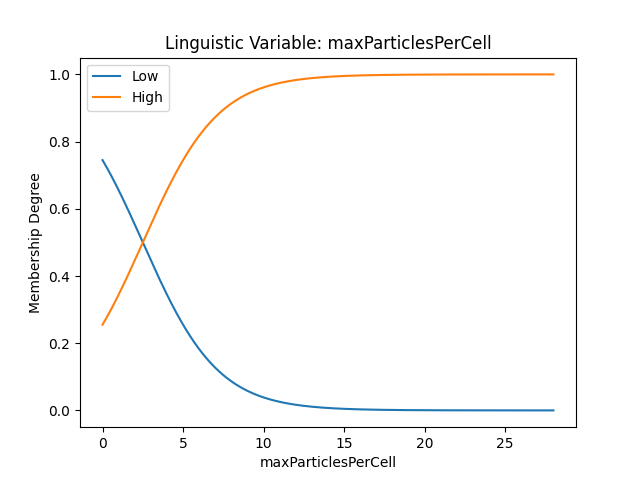

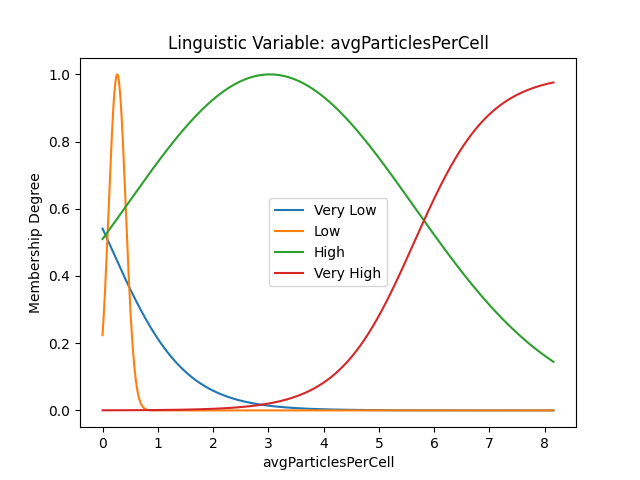

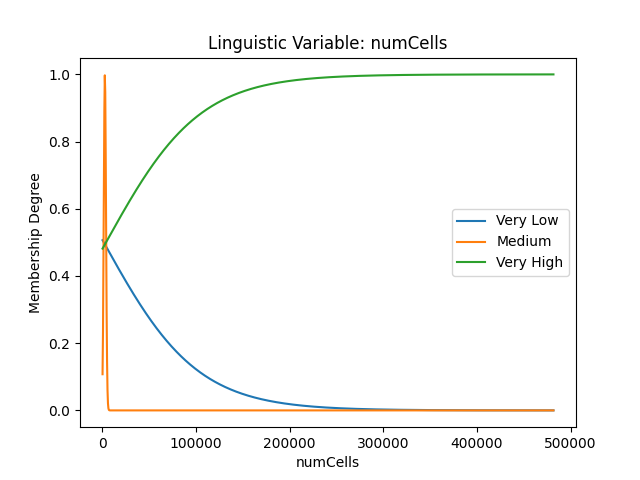

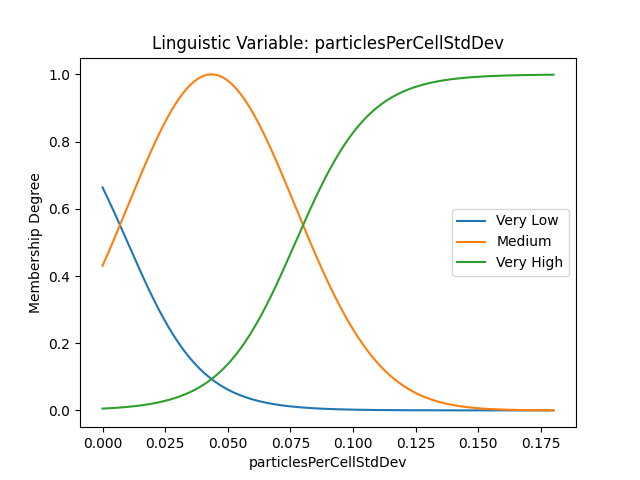

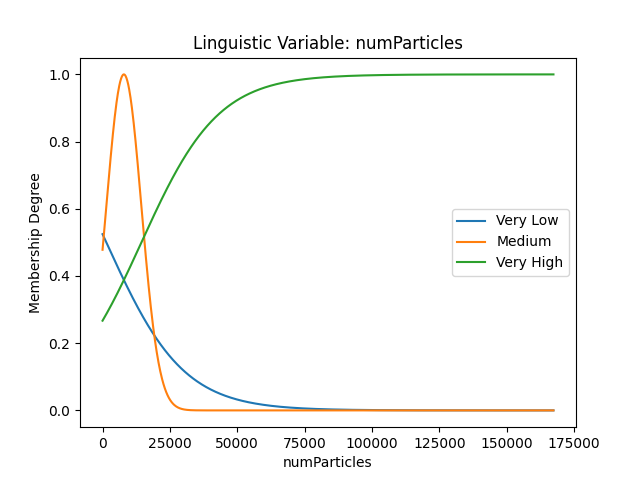

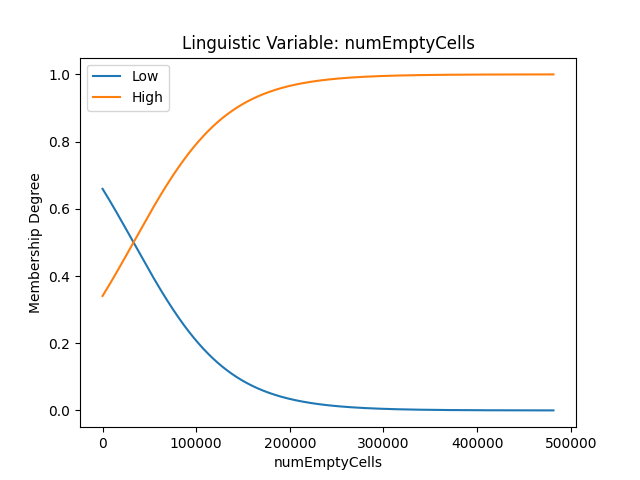

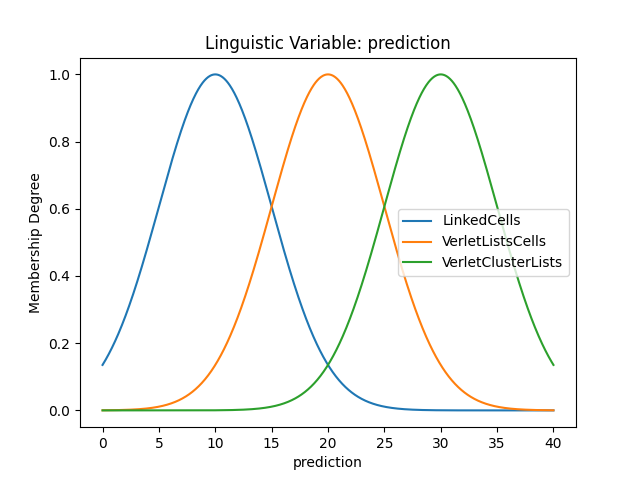

In [178]:
for i in inputVariables:
    fig, ax = plt.subplots()
    i.plot(ax)

In [179]:
rules = []


def constructFuzzySet(terms: list[list[tuple[str, str]]]):
    fuzzySet = None
    for and_list in terms:
        or_set = None
        for (term, value) in and_list:
            a = list(filter(lambda x: x.name == term, inputVariables))[0]
            or_set = (a == value) | or_set if or_set is not None else (
                a == value)
        fuzzySet = fuzzySet & or_set if fuzzySet is not None else or_set
    return fuzzySet


def parseRules(rulesString: str):
    andLists = []
    for antecedent in rulesString.split("&&"):
        andString = re.search(r"\((.+)\)", antecedent).group(1)
        orStrings = andString.split("||")

        or_list = []
        # (avgParticlesPerCell == "Very Low")
        #
        for orString in orStrings:
            term = re.search(r"\(?(\w+) == \"(.*)\"\)?", orString)
            or_list.append((term.group(1), term.group(2)))

        andLists.append(or_list)

    return andLists


for rule in rulesString.strip().split("\n"):
    antecedentsString = re.search(r"if (.+) then", rule).group(1)
    consequentList = re.search(r"then (.+)", rule).group(1)

    antecedent = constructFuzzySet(parseRules(antecedentsString))

    consequent = constructFuzzySet(parseRules(consequentList))

    rules.append(FuzzyRule(antecedent, consequent))

In [180]:
fisys = FuzzySystem()

for rule in rules:
    fisys.addRule(rule)

In [181]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")

In [182]:
from collections import defaultdict


freq_correct_test = defaultdict(int)
freq_total_test = defaultdict(int)

freq_correct_train = defaultdict(int)
freq_total_train = defaultdict(int)

for row in test.iterrows():
    val, pred = fisys.predictClosest(row[1], algo_ranking)

    true = row[1]["Container"]
    if pred == true:
        freq_correct_test[true] = freq_correct_test.get(true, 0) + 1
    freq_total_test[true] = freq_total_test.get(true, 0) + 1

for row in train.iterrows():
    val, pred = fisys.predictClosest(row[1], algo_ranking)

    true = row[1]["Container"]
    if pred == true:
        freq_correct_train[true] = freq_correct_train.get(true, 0) + 1
    freq_total_train[true] = freq_total_train.get(true, 0) + 1

In [184]:
print("Number of rules: ", len(rules))
print("Number of input variables: ", len(inputVariables))

freq_total_test["Total"] = sum(freq_total_test.values())
freq_correct_test["Total"] = sum(freq_correct_test.values())

freq_total_train["Total"] = sum(freq_total_train.values())
freq_correct_train["Total"] = sum(freq_correct_train.values())

print("\nTest Accuracy:")
for key in freq_total_test.keys():
    print(f"\t{key:24}: {freq_correct_test[key] / (freq_total_test[key] or 1):.2f} ({
          freq_correct_test[key]}/{freq_total_test[key]})")

print("\nTrain Accuracy:")
for key in freq_total_train.keys():
    print(f"\t{key:24}: {freq_correct_train[key] / (freq_total_train[key] or 1):.2f} ({
          freq_correct_train[key]}/{freq_total_train[key]})")

Number of rules:  36
Number of input variables:  7

Test Accuracy:
	VerletListsCells        : 1.00 (8/8)
	LinkedCells             : 1.00 (1/1)
	VerletClusterLists      : 1.00 (3/3)
	Total                   : 1.00 (24/24)

Train Accuracy:
	VerletListsCells        : 0.92 (23/25)
	VerletClusterLists      : 0.95 (18/19)
	LinkedCells             : 1.00 (1/1)
	Total                   : 0.93 (84/90)


# Findings

- MoM works way better than the other methods.
- This is probably since the output variable is categorical and therefore interpolating between them is not a good idea.
  - Also the placement on the x-axis is somehow arbitrary. This also makes interpolation meaningless
